<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Homework-3" data-toc-modified-id="Homework-3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework 3</a></span></li><li><span><a href="#1.-Eurostat" data-toc-modified-id="1.-Eurostat-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1. Eurostat</a></span></li><li><span><a href="#TODO-=-Regler-fin-de-la-partie-avec-la-Suisse" data-toc-modified-id="TODO-=-Regler-fin-de-la-partie-avec-la-Suisse-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TODO = Regler fin de la partie avec la Suisse</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-data-from-eurostat" data-toc-modified-id="Load-data-from-eurostat-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Load data from eurostat</a></span></li><li><span><a href="#Load-data-from-topojson" data-toc-modified-id="Load-data-from-topojson-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Load data from topojson</a></span></li></ul></li></ul></li><li><span><a href="#TODO" data-toc-modified-id="TODO-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>TODO</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Map-presenting-job-seekers-rate-by-canton" data-toc-modified-id="Map-presenting-job-seekers-rate-by-canton-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Map presenting job seekers rate by canton</a></span></li><li><span><a href="#Map-presenting-unemployed-job-seekers-rate-by-canton" data-toc-modified-id="Map-presenting-unemployed-job-seekers-rate-by-canton-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Map presenting unemployed job seekers rate by canton</a></span></li><li><span><a href="#3.-Unemployment-rate-between-Swiss-and-Foreign-workers" data-toc-modified-id="3.-Unemployment-rate-between-Swiss-and-Foreign-workers-4.0.3"><span class="toc-item-num">4.0.3&nbsp;&nbsp;</span>3. Unemployment rate between Swiss and Foreign workers</a></span></li></ul></li></ul></li></ul></div>

# Homework 3

In [1]:
import os
import pandas as pd
import json
import folium
import branca
import math
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Eurostat
Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

[eurostat dataset](http://ec.europa.eu/eurostat/tgm/refreshTableAction.do?tab=table&plugin=1&pcode=tesem120&language=en) second dataset (missing values but can be partitionned into male/female)

Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

# TODO = Regler fin de la partie avec la Suisse

### Load data from eurostat
We downloaded the unemployment dataset from eurostat for the past nine years. After converting the file to CSV for encoding reasons and cleaning the useless columns, we can start our analysis of the European unemployment rate. If you take a look at the csv file you will notice that the missing rates are assigned to the value `:` which we replaced by `NaN`.

In [53]:
#load csv file of second dataset 
eurostat2_data = pd.read_excel('eurostat/eurostat2.xls', header=3, skip_footer=8, na_values=':')

In [263]:
eurostat2_data = eurostat2_data.iloc[:,[0,-1]] 

In [264]:
eurostat2_data.columns = ['Country', 'Rate']

In [265]:
eurostat2_data = eurostat2_data.set_index(['Country'])
eurostat2_data.tail(10)

,Rate
Country,
Liechtenstein,NaN
Norway,4.7
Switzerland,NaN
Montenegro,NaN
"Former Yugoslav Republic of Macedonia, the",NaN
Albania,NaN
Serbia,NaN
Turkey,10.9
United States,4.9


We can observe that some values in the second dataset are not numeric, we will then retrieve them. Some values are meaningless as they are not part of Europe.


In [266]:
eurostat2_data = eurostat2_data.dropna()

### Load data from topojson

Now that we have the necessary information to build our map we will use the topojson file to map the unemployments rates to each country on our map.

In [267]:
#load topojson data
eu_json_path = r'topojson/europe.topojson.json'
eu_json_data = json.load(open(eu_json_path))#['objects']['europe']['geometries']

In [268]:
elements = eu_json_data['objects']['europe']['geometries']
countries = [c['properties']['NAME'] for c in elements]
countries.sort()

The following `NaN` values correspond to the countries in topojson for which no unemployment rate is listed.

In [269]:
eurostat2_data = eurostat2_data.loc[countries]
eurostat2_data.head(10)

,Rate
Country,
Albania,NaN
Andorra,NaN
Armenia,NaN
Austria,6.0
Azerbaijan,NaN
Belarus,NaN
Belgium,7.8
Bosnia and Herzegovina,NaN
Bulgaria,7.6


In [25]:
def unemployed_color_scale(max_):
    colorscale = branca.colormap.linear.YlOrRd.scale(0, max_)
    colorscale.caption = "Unemployment rate (%)"
    return colorscale

Style function to obtain map.

In [271]:
eu_map = folium.Map(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ')
colorscale = unemployed_color_scale(eurostat2_data['Rate'].max())

def style_function(feature):
    country = feature['properties']['NAME']
    rate = eurostat2_data.loc[country, 'Rate']
    return {
        'fillOpacity': 1 if not np.isnan(rate) else 0,
        'weight': 0,
        'fillColor': colorscale(rate) if not np.isnan(rate) else 0,
        'weight': 1,
        'opacity': 1 if not np.isnan(rate) else 0,
        'color': 'white',
    }

f = folium.TopoJson(
    eu_json_data, 
    'objects.europe',
    name = 'topojson',
    style_function = lambda c: style_function(c)
    ).add_to(eu_map)


eu_map.add_child(colorscale)
eu_map.fit_bounds(f.get_bounds())
eu_map

# TODO

- Add name in the middle of each canton
- Better color scheme ?
- Better way to see difference than two distinct maps

We downloaded the unemployment dataset from [amstat](https://www.amstat.ch/v2/index.jsp?lang=fr) for the month of September 2017. After converting the file to CSV for encoding reasons and cleaning the useless columns, we can start our analysis of the Swiss unemployment rate. 

In [272]:
cantons_topojson = './topojson/ch-cantons.topojson.json'
data_path = './amstat/dataset-q1.csv'

In [273]:
with open(data_path, 'r') as f:
    dataframe = pd.read_csv(f, thousands="'", na_values='...')

In [274]:
dataframe = dataframe.loc[:25,:]  # remove total row
dataframe['Population active'] = (dataframe["Demandeurs d'emploi"] * 100 / dataframe['Taux de chômage']).astype('int64')
dataframe = dataframe.set_index(['Canton'])

In [275]:
dataframe.head(10)

,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Population active
Canton,,,,,
Zurich,3.3,27225,34156,6931,1035030
Berne,2.4,13658,18385,4727,766041
Lucerne,1.7,3885,6756,2871,397411
Uri,0.6,112,257,145,42833
Schwyz,1.7,1455,2229,774,131117
Obwald,0.7,153,319,166,45571
Nidwald,1.0,248,436,188,43600
Glaris,1.8,416,713,297,39611
Zoug,2.3,1543,2615,1072,113695


We are going to find a maping between the map canton names and the unemployment data canton names. Most are correct if we order each by alphabetical order and put them together, we will fix the few errors by hand.

In [276]:
with open(cantons_topojson) as f:
    cantons_json = json.load(f)
    
cantons_map = [canton['properties']['name'] for canton in cantons_json['objects']['cantons']['geometries']]
cantons_map = sorted(cantons_map)
cantons_map2df = dict(zip(cantons_map, sorted(dataframe.index.values)))

cantons_map2df['Aargau'] = 'Argovie'
cantons_map2df['Appenzell Ausserrhoden'] = 'Appenzell Rhodes-Extérieures'
cantons_map2df['Appenzell Innerrhoden'] = 'Appenzell Rhodes-Intérieures'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Stadt'] = 'Bâle-Ville'
cantons_map2df['Thurgau'] = 'Thurgovie'
cantons_map2df['Ticino'] = 'Tessin'

We create the Swiss map and the color scale.

In [2]:
def create_swiss_map():
    switzerland = (46.5, 8.23)
    return folium.Map(location=switzerland, zoom_start=7.7, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ')

colorscale = unemployed_color_scale(6)

NameError: name 'unemployed_color_scale' is not defined

In [278]:
m = create_swiss_map()
m.add_child(colorscale)

def style_function(canton, df_field):
    canton_name = canton['properties']['name']
    unemployment_rate = dataframe.loc[cantons_map2df[canton_name], df_field]
    return {
        'fillOpacity': 1,
        'weight': 0,
        'fillColor': colorscale(unemployment_rate),
        'weight': 1,
        'opacity': 1,
        'color': 'white',
    }

cantons_poly = folium.TopoJson(
    open(cantons_topojson),
    'objects.cantons',
    name='cantons',
    style_function=lambda c: style_function(c, 'Taux de chômage')
)
cantons_poly.add_to(m);

### Map presenting job seekers rate by canton

In [279]:
m

We now compute the number of job seekers who have a job, to differentiate with the Federal way of computing the unemployment rate.

In [280]:
dataframe['Taux de demandeur chômeur'] = round(100 * (dataframe["Demandeurs d'emploi"] - dataframe["Demandeurs d'emploi non chômeurs"]) /  dataframe['Population active'], 1)
dataframe.head()

,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Population active,Taux de demandeur chômeur
Canton,,,,,,
Zurich,3.3,27225,34156,6931,1035030,2.6
Berne,2.4,13658,18385,4727,766041,1.8
Lucerne,1.7,3885,6756,2871,397411,1.0
Uri,0.6,112,257,145,42833,0.3
Schwyz,1.7,1455,2229,774,131117,1.1


In [281]:
m = create_swiss_map()
m.add_child(colorscale)

cantons_poly = folium.TopoJson(
    open(cantons_topojson),
    'objects.cantons',
    name='cantons',
    style_function=lambda c: style_function(c, 'Taux de demandeur chômeur')
)
cantons_poly.add_to(m);

### Map presenting unemployed job seekers rate by canton

In [282]:
m

To compare more easily the impact on the statistics of job seekers already having a job, we show the following bar plot.

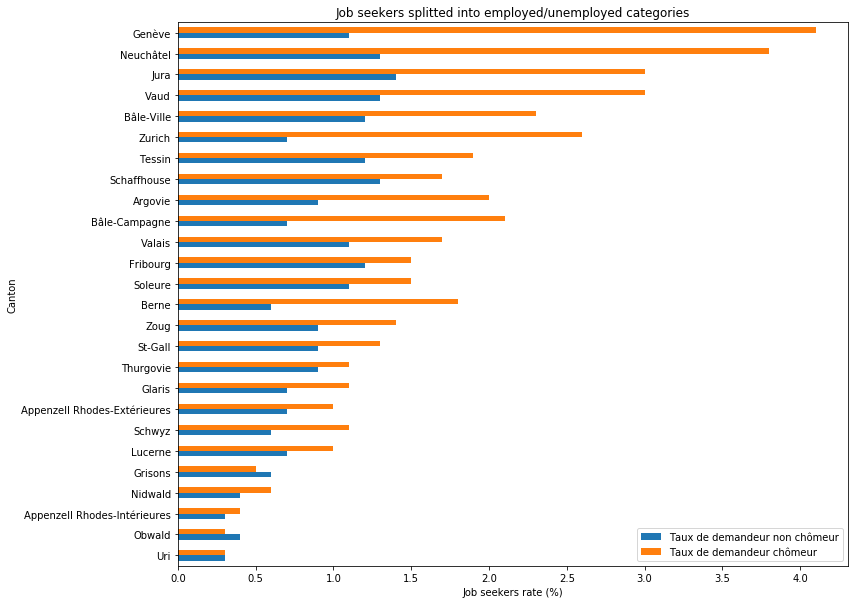

In [283]:
import matplotlib.pyplot as plt

dataframe['Taux de demandeur non chômeur'] = dataframe["Taux de chômage"] - dataframe["Taux de demandeur chômeur"]
ax = dataframe.sort_values('Taux de chômage').loc[:, ['Taux de demandeur non chômeur', 'Taux de demandeur chômeur']].plot(kind='barh', figsize=(12,10));
ax.set_xlabel('Job seekers rate (%)');
ax.set_title('Job seekers splitted into employed/unemployed categories');

### 3. Unemployment rate between Swiss and Foreign workers

**TODO: do we need to take into account age groups and nationality for each canton ?**

**TODO: cantons with the highest proportion of unemployed foreigners : why ? Maybe because three of them are among the cantons with the lowest population.**

An excel dataset that includes the unemployment rates in Switzerland is loaded from the amstat website. It contains unemployment rate, number of unemployed persons registered, coefficients of variation for each month of 2017 per canton for both swiss and foreign workers.

In [18]:
# Loading of excel file
df = pd.read_excel('amstat/Taux_chomage_2017.xlsx')
df.head()

,Canton,Nationalité,Mois,Unnamed: 3,Janvier 2017,Unnamed: 5,Unnamed: 6,Février 2017,Unnamed: 8,Unnamed: 9,...,Unnamed: 23,Unnamed: 24,Août 2017,Unnamed: 26,Unnamed: 27,Septembre 2017,Unnamed: 29,Unnamed: 30,Total,Unnamed: 32
0,NaN,NaN,Mesures,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,...,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits
1,Zurich,Etrangers,NaN,6.6,A,15060,6.5,A,14787,6.3,...,12546,5.3,A,12151,5.3,A,12111,5.9,A,120430
2,Zurich,Suisses,NaN,2.9,A,17327,2.8,A,16832,2.8,...,15446,2.6,A,15363,2.5,A,15114,2.7,A,143239
3,Berne,Etrangers,NaN,7.5,A,6670,7.4,A,6562,7.1,...,4911,5.5,A,4913,5.5,A,4900,6.4,A,50777
4,Berne,Suisses,NaN,2.2,A,10284,2.1,A,10176,2.1,...,8722,1.9,A,8916,1.8,A,8758,2,A,83379


The dataset is processed in order to keep only interesting features, that is canton name, nationality (swiss or foreign), unemployment rates for each month and total. Number of registered unemployed persons and coefficients of variation for each month are removed.



In [19]:
# Data cleaning:

column_names = df.columns[list(name[0:6] != 'Unname' for name in df.columns )] 
drop_column = df.columns[list(((str(col_name)[0:4] == 'Coef') | (str(col_name)[0:2] == 'Ch')) for col_name in df.loc[0])]
df = df.drop(drop_column, axis = 1)
df.columns = column_names
df = df.drop('Mois', axis = 1)
df = df.drop(0,axis = 0)
df[df.columns.values[2:]] = df[df.columns.values[2:]].astype(np.float)
df = df.set_index('Canton')
df.head()

,Nationalité,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Total
Canton,,,,,,,,,,,
Zurich,Etrangers,6.6,6.5,6.3,6.0,5.7,5.6,5.5,5.3,5.3,5.9
Zurich,Suisses,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5,2.7
Berne,Etrangers,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5,6.4
Berne,Suisses,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8,2.0
Lucerne,Etrangers,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9,4.5


We decided to create two datasets, one for foreign people and one for swiss people.

In [20]:
# Foreign people dataset
df_foreign = df[df.Nationalité == 'Etrangers']
df_foreign.head()

,Nationalité,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Total
Canton,,,,,,,,,,,
Zurich,Etrangers,6.6,6.5,6.3,6.0,5.7,5.6,5.5,5.3,5.3,5.9
Berne,Etrangers,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5,6.4
Lucerne,Etrangers,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9,4.5
Uri,Etrangers,6.9,6.4,5.8,5.3,4.1,3.0,2.7,2.2,2.1,4.3
Schwyz,Etrangers,4.6,4.5,4.3,4.0,3.6,3.5,3.5,3.5,3.4,3.9


In [21]:
# swiss people dataset
df_swiss = df[df.Nationalité == 'Suisses']
df_swiss.head()

,Nationalité,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Total
Canton,,,,,,,,,,,
Zurich,Suisses,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5,2.7
Berne,Suisses,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8,2.0
Lucerne,Suisses,1.5,1.5,1.4,1.3,1.3,1.2,1.3,1.3,1.3,1.3
Uri,Suisses,0.7,0.7,0.6,0.6,0.6,0.5,0.4,0.4,0.4,0.5
Schwyz,Suisses,1.4,1.4,1.3,1.2,1.2,1.1,1.2,1.2,1.2,1.2


The swiss cantons TopoJson file is imported

In [22]:
# import swiss cantons topojson file
swiss_cantons = r'topojson/ch-cantons.topojson.json'
swiss_cantons_json_data = json.load(open(swiss_cantons))

The same maping as before is done between the map canton names and the unemployment data canton names. 

In [23]:
cantons_map = [canton['properties']['name'] for canton in swiss_cantons_json_data['objects']['cantons']['geometries']]
cantons_map = sorted(cantons_map)
cantons_map2df = dict(zip(cantons_map, sorted(df_foreign.index.values)))

cantons_map2df['Aargau'] = 'Argovie'
cantons_map2df['Appenzell Ausserrhoden'] = 'Appenzell Rhodes-Extérieures'
cantons_map2df['Appenzell Innerrhoden'] = 'Appenzell Rhodes-Intérieures'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Stadt'] = 'Bâle-Ville'
cantons_map2df['Thurgau'] = 'Thurgovie'
cantons_map2df['Ticino'] = 'Tessin'

Using the dictionnary created above, we add abbreviation names of cantons in both dataframes and set these abbreviations as index, so that dataframe will match with TopoJson file.

We define functions that will be used to create a map showing the unemployment rate at the level of swiss cantons:
- A colorscale is created to define the colour to use for a specific canton in terms of its unemployment rate.
- "style_function" allows to add the colorscale corresponding to unemployment rate for each canton on the swiss map.
- "map_generation" creates the swiss map, adds the TopoJson file with the style function generated by the function described above.

In [26]:
colorscale = unemployed_color_scale(9)

def style_function(canton, df_field, df_nationality):
    canton_name = canton['properties']['name']
    unemployment_rate = df_nationality.loc[cantons_map2df[canton_name], df_field]
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':colorscale(unemployment_rate),
        'weight': 1,
        'opacity': 1,
        'color': 'white',
    }

def map_generation(df_field, df_nationality,map_name):
    cantons_poly = folium.TopoJson(
        swiss_cantons_json_data,
        'objects.cantons',
        name='cantons',
        style_function=lambda c: style_function(c, df_field, df_nationality)
        ).add_to(map_name)
    map_name.add_child(colorscale)
    

A map showing the unemployment rate per canton for foreign people is created.

In [27]:
# Unemployment rate for foreign people

cantons_map_foreign = create_swiss_map()
df_field = 'Septembre 2017'
map_generation(df_field, df_foreign, cantons_map_foreign)
cantons_map_foreign


A map showing the unemployment rate per canton for foreign people is created.

In [28]:
# Unemployment rate for swiss people
cantons_map_swiss = create_swiss_map()
df_field = 'Septembre 2017'
df_nationality = df_swiss
map_generation(df_field,df_nationality,cantons_map_swiss)
cantons_map_swiss


To show the difference in unemployment rates between foreign people and swiss people in each canton on a map, we decided to calculate the proportion of unemployed foreigners: 

- proportion = foreigners unemployment rate/ total unemployment rate 

Thus, a high proportion indicates that unemployment rate for foreign people is higher than the one for swiss people.

In [11]:
# Create map
m_proportion_foreigner = create_swiss_map()

# Define colorscale
colorscale_foreign_proportion = branca.colormap.linear.YlGnBu.scale(0, 1)
colorscale_foreign_proportion.caption = 'Proportion of unemployed foreigners'

# Choose the month: we have chosen the most recent date
month = 'Septembre 2017'

# Proportion of unemployed foreigners is computed 
proportion_foreigners = df_foreign[month] / (df_foreign[month] + df_swiss[month])

def style_function_proportion_foreigner(canton):
    proportion = proportion_foreigners[cantons_map2df[canton['properties']['name']]]
    return {
        'fillOpacity': 0.3,
        #'weight': 0,
        'fillColor': colorscale_foreign_proportion(proportion),
        #'weight': 1,
        'opacity': 1,
        'color': 'white',
    }


cantons_poly = folium.TopoJson(
    swiss_cantons_json_data,
    'objects.cantons',
    name='cantons',
    style_function=lambda c: style_function_proportion_foreigner(c)
    ).add_to(m_proportion_foreigner)

m_proportion_foreigner.add_child(colorscale_foreign_proportion)

As explained before, the are cantons where the proportion of unemployed foreigners is the highest.

*Unemployment rate between aged groups :*

In [12]:
# Load excel dataset
df_age = pd.read_excel('amstat/Taux_chomage_age.xlsx')
df_age.head()

,Canton,"Classes d'âge 15-24, 25-49, 50 ans et plus",Unnamed: 2,Mois,Unnamed: 4,Septembre 2017,Unnamed: 6,Unnamed: 7,Total,Unnamed: 9
0,NaN,NaN,NaN,Mesures,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits
1,Zurich,1.0,15-24 ans,NaN,3.7,A,3420,3.7,A,3420
2,Zurich,2.0,25-49 ans,NaN,3.4,A,17053,3.4,A,17053
3,Zurich,3.0,50 ans et plus,NaN,2.9,A,6752,2.9,A,6752
4,Berne,1.0,15-24 ans,NaN,2.8,B,2003,2.8,B,2003


The dataset is processed in order to keep only interesting features, that is canton name, age groups and unemployment rate for september 2017. Number of registered unemployed persons and coefficients of variation are removed.

In [13]:
# Data cleaning:

column_names = ['Cantons','Classes d age','age','taux chomage septembre 2017']
df_age = df_age.drop(['Mois','Septembre 2017','Unnamed: 6','Unnamed: 7','Total','Unnamed: 9' ], axis = 1)
df_age.columns = column_names
df_age = df_age.drop([0,79],axis = 0)
df_age.head()

,Cantons,Classes d age,age,taux chomage septembre 2017
1,Zurich,1.0,15-24 ans,3.7
2,Zurich,2.0,25-49 ans,3.4
3,Zurich,3.0,50 ans et plus,2.9
4,Berne,1.0,15-24 ans,2.8
5,Berne,2.0,25-49 ans,2.5


A bar plot is created to visualize unemployment rate per age group for each canton.

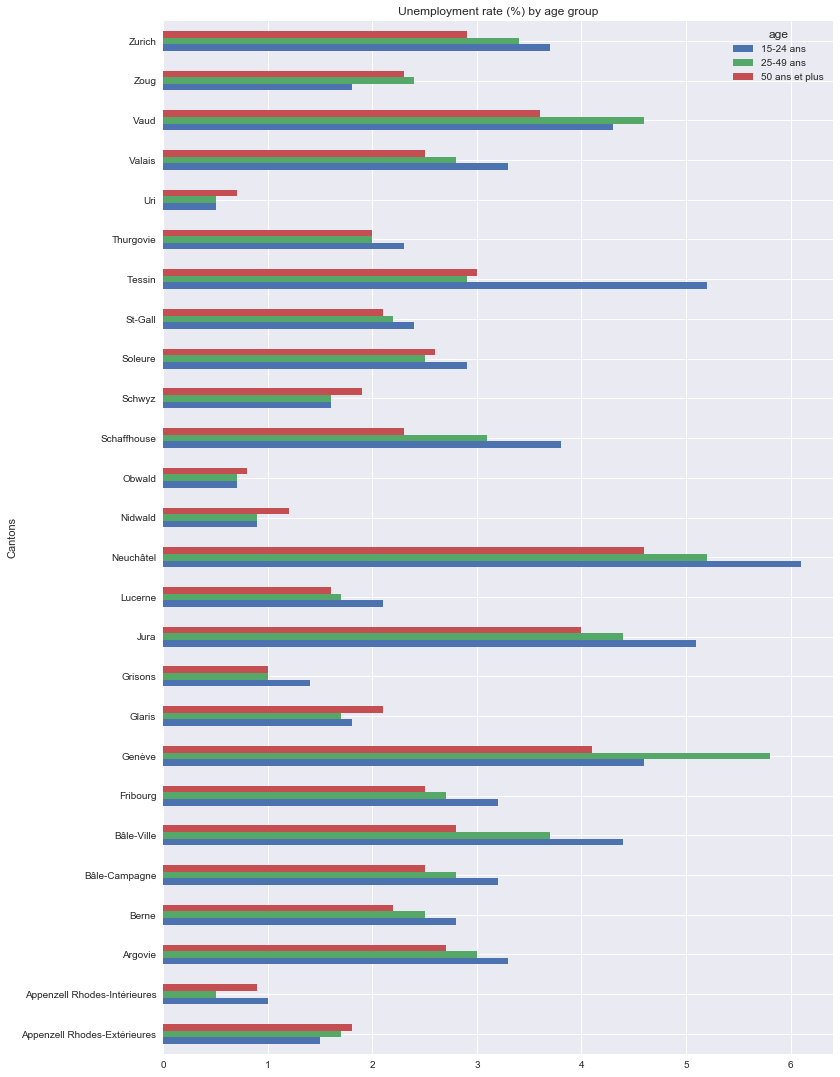

In [14]:
df_age['taux chomage septembre 2017'] = df_age['taux chomage septembre 2017'].astype('float')
import seaborn as sns
df_by_age = df_age.loc[:,['Cantons', 'age', 'taux chomage septembre 2017']]  # .plot(kind='barh', figsize=(12,10))
df_by_age = df_by_age.pivot(index='Cantons', columns='age')
df_by_age.columns = df_by_age.columns.droplevel()
ax = df_by_age.plot(kind='barh', figsize=(12,19));
ax.set_title('Unemployment rate (%) by age group');

In [29]:
cantons_map_foreign.save('cantons_map_foreign.html')
cantons_map_swiss.save('cantons_map_swiss.html')
m_proportion_foreigner.save('m_proportion_foreigner.html')

In [30]:
cantons_map_foreign